In [50]:
# Steps required
# Create a data pipeline that reads in image from file directory and is able to pass the image to model for training

# Design of U-Net backbone

# Design of CBAM attention model

# Design of U-Net integrated with CBAM and the skip connections

# Design of loss functions

# Design of visualisation to evaluate model
    # 1. Generate ground truth after a certain number of epochs
    # 2. Training curves
    # 3. Grad-CAM mask (mentioned in CBAM paper)

In [51]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import os
import sys

sys.path.append(os.path.join(os.getcwd(), '..', 'input', 'cbam-unet'))
sys.path.append(os.path.join(os.getcwd(), '..', 'helpers'))

from cbam_unet import *
from visualisation_helpers import *

# %load_ext autoreload
# %autoreload 2

In [52]:
print(tf.version.VERSION)
print(tf.config.list_physical_devices('GPU'))

2.13.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# 0. Read in images and preprocess them
Source: https://www.tensorflow.org/tutorials/load_data/images

- Step 1: Specify batch size and image dimensions (Specifying the dimension results in Tensorflow cropping the image for you)
- Step 2: Split the dataset into train and validation split
- Step 3: Normalise the pixel values

In [53]:
# Step 1

train_batch_size = 8 # change back to 8 later
val_batch_size = 10 # change back to 10 later
img_height = 400
img_width = 400
num_channels = 3

In [54]:
# Step 2
# Use a seed of 1 to ensure reproducibility of results
# Use ImageDataGenerator instead

seed = 1
#imgs_dir = os.path.join(os.path.dirname(os.getcwd()), 'datasets/train/image')
#labels_dir = os.path.join(os.path.dirname(os.getcwd()), 'datasets/train/groundtruth')

imgs_dir = os.path.join(os.path.dirname(os.getcwd()), 'input', 'road-segmentation-ds', 'training', 'images')
labels_dir = os.path.join(os.path.dirname(os.getcwd()), 'input', 'road-segmentation-ds', 'training', 'groundtruth')

# Equivalent to x_train
train_imgs_ds = tf.keras.utils.image_dataset_from_directory(
  imgs_dir,
  validation_split=0.1,
  subset="training",
  seed=seed,
  labels=None,
  image_size=(img_height, img_width),
  batch_size=train_batch_size)

# Equivalent to x_val
val_imgs_ds = tf.keras.utils.image_dataset_from_directory(
  imgs_dir,
  validation_split=0.1,
  subset="validation",
  seed=seed,
  labels=None,
  image_size=(img_height, img_width),
  batch_size=val_batch_size)

# Equivalent to y_train
train_gts_ds = tf.keras.utils.image_dataset_from_directory(
  labels_dir,
  color_mode="grayscale",
  validation_split=0.1,
  subset="training",
  labels=None,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=train_batch_size)

# Equivalent to y_val
val_gts_ds = tf.keras.utils.image_dataset_from_directory(
  labels_dir,
  color_mode="grayscale",
  validation_split=0.1,
  subset="validation",
  seed=seed,
  labels=None,
  image_size=(img_height, img_width),
  batch_size=val_batch_size)

Found 100 files belonging to 1 classes.
Using 90 files for training.
Found 100 files belonging to 1 classes.
Using 10 files for validation.
Found 100 files belonging to 1 classes.
Using 90 files for training.
Found 100 files belonging to 1 classes.
Using 10 files for validation.


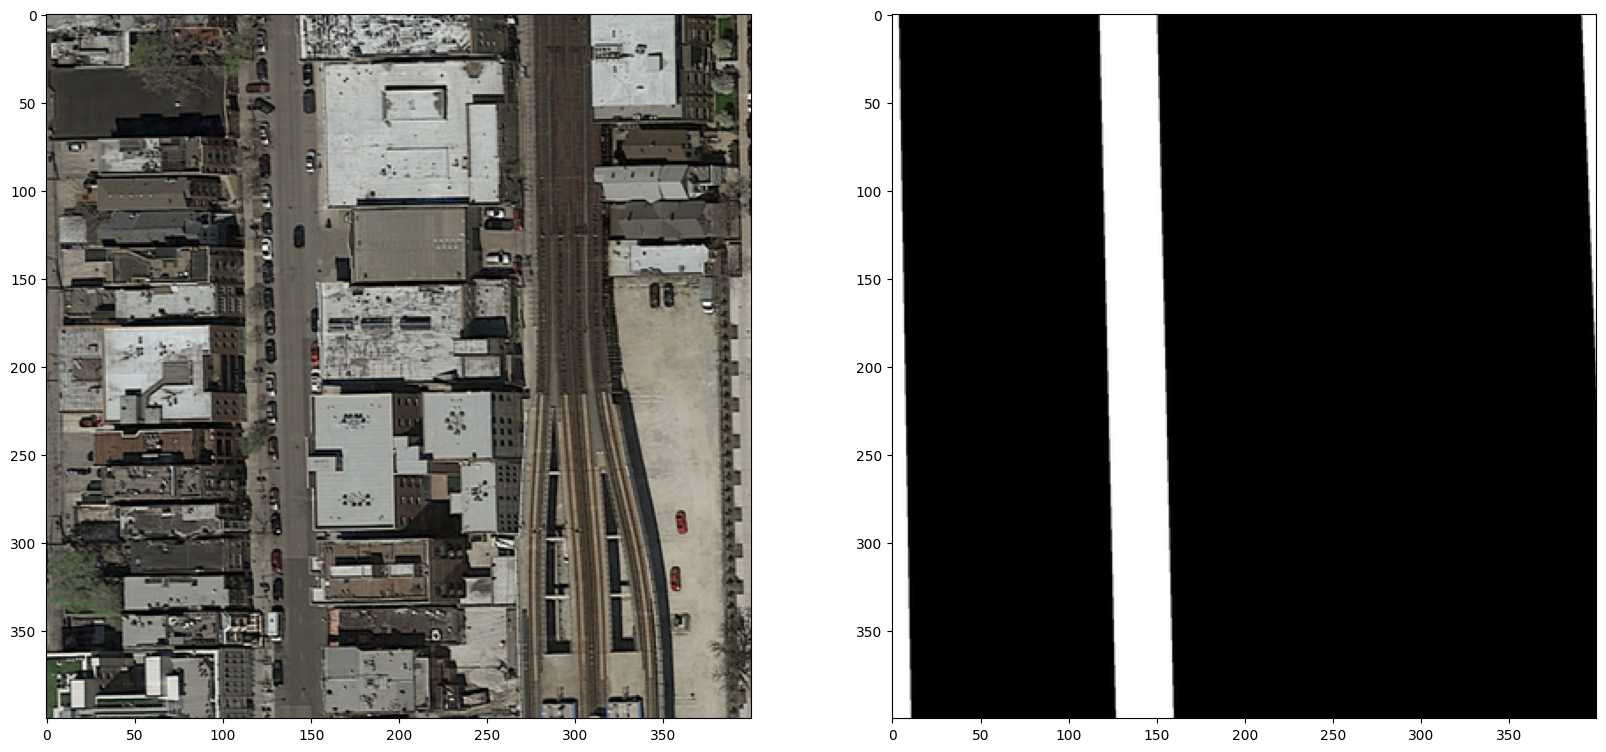

In [55]:
_imgs = []
_gts = []

for images in train_imgs_ds.take(1):
    for i in range(1):
        _imgs.append(images[i].numpy().astype("uint8"))

for gts in train_gts_ds.take(1):
    for i in range(1):
        _gts.append(gts[i].numpy().astype("uint8"))

fig, axs = plt.subplots(1,2)
#fig, axs = plt.subplots(2,2, figsize=(6, 8))

axs[0].imshow(_imgs[0])
axs[1].imshow(_gts[0], cmap="gray")
                   
#axs[1][0].imshow(_imgs[1])
#axs[1][1].imshow(_gts[1], cmap="gray")

In [56]:
# Step 3
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_imgs_ds = train_imgs_ds.map(lambda x: (normalization_layer(x)))
val_imgs_ds = val_imgs_ds.map(lambda x: (normalization_layer(x)))

train_gts_ds = train_gts_ds.map(lambda x: (normalization_layer(x)))
val_gts_ds = val_gts_ds.map(lambda x: (normalization_layer(x)))

In [57]:
sample_img_batch = next(iter(train_imgs_ds))
sample_image = sample_img_batch[0]

sample_gt_batch = next(iter(train_gts_ds))
sample_gt = sample_gt_batch[0]

print(f'Sample image, min. pixel value: {np.min(sample_image)}, max. pixel value: {np.max(sample_image)}')
print(f'Sample gt, min. pixel value: {np.min(sample_gt)}, max. pixel value: {np.max(sample_gt)}')

Sample image, min. pixel value: 0.0, max. pixel value: 1.0
Sample gt, min. pixel value: 0.0, max. pixel value: 0.9294118285179138


# 1. Instantiate model and train model

In [58]:
# Show summary of the model
input_shape = (None, img_height, img_width, num_channels)
cbam_unet_model = CBAM_UNet(input_shape)
cbam_unet_model.build(input_shape) # input shape: (None, 400, 400, 3)
cbam_unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 encoder__conv_block_10 (En  (None, 400, 400, 64)         38720     ['input_2[0][0]']             
 coder_ConvBlock)                                                                                 
                                                                                                  
 max_pooling2d_524 (MaxPool  (None, 200, 200, 64)         0         ['encoder__conv_block_10[0][0]
 ing2D)                                                             ']                            
                                                                                            

In [61]:
# Write training loop for model

# Hyperparameters
num_epochs = 200 # 100
generate_every = 25 # 10
lr = 0.00001

# Arrays to store results
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_ious = []
val_ious = []
train_dices = []
val_dices = []

# Convert datasets into an list for easy iteration
train_imgs = list(iter(train_imgs_ds))
train_gts = list(iter(train_gts_ds))
val_imgs = list(iter(val_imgs_ds))
val_gts = list(iter(val_gts_ds))

# Instantiate model
input_shape = (None, img_height, img_width, num_channels)
cbam_unet_model = CBAM_UNet(input_shape)

# Define optimiser
optimiser = tf.keras.optimizers.Adam(learning_rate = lr)
cbam_unet_model.compile(optimizer = optimiser)

# Start training loop
for epoch in range(num_epochs):
    
    print(f'Start of epoch {epoch}.')
    for batch_no, train_imgs_batch in enumerate(train_imgs):
        
        with tf.GradientTape() as tape:
                        
            # Pass images into model and get prediction
            train_outputs = cbam_unet_model(train_imgs[batch_no])
                          
            # Calculate loss
            train_loss = cbam_unet_model.compute_loss(train_gts[batch_no], train_outputs)
    
        # Compute and apply gradients
        grads = tape.gradient(train_loss, cbam_unet_model.trainable_weights)
        optimiser.apply_gradients(zip(grads, cbam_unet_model.trainable_weights))
    
    # Calculate on validation set
    val_outputs = cbam_unet_model(val_imgs[0]) # only one batch for validation
    val_loss = cbam_unet_model.compute_loss(val_gts[0], val_outputs)

    # Compute metrics
    train_acc, train_iou, train_dice = cbam_unet_model.compute_metrics(train_gts[batch_no], train_outputs)
    val_acc, val_iou, val_dice = cbam_unet_model.compute_metrics(val_gts[0], val_outputs)
        
    # Save results
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_ious.append(train_iou)
    train_dices.append(train_dice)
    
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_ious.append(val_iou)
    val_dices.append(val_dice)
    
    print(f'tr_Loss: {train_loss}, tr_acc: {train_acc}, tr_iou: {train_iou}, tr_dice: {train_dice}')
    print(f'val_Loss: {val_loss}, val_acc: {val_acc}, val_iou: {val_iou}, val_dice: {val_dice}')
    
    # Generate the segmentation map and save it every 'generate_every' epochs
    if epoch % generate_every == 0 and epoch > 0:
        np.save(f'train_epoch_{epoch}', train_outputs[0])

Start of epoch 0.
tr_Loss: 0.86463463306427, tr_acc: 0.08138176053762436, tr_iou: 0.03899607062339783, tr_dice: 0.07234036922454834
val_Loss: 0.8398281335830688, val_acc: 0.0978129431605339, val_iou: 0.0072870380245149136, val_dice: 0.013582350686192513
Start of epoch 1.
tr_Loss: 0.8642152547836304, tr_acc: 0.082175612449646, tr_iou: 0.03909536451101303, tr_dice: 0.07251130044460297
val_Loss: 0.8393187522888184, val_acc: 0.09871785342693329, val_iou: 0.007282118313014507, val_dice: 0.013573819771409035
Start of epoch 2.
tr_Loss: 0.863840639591217, tr_acc: 0.08286136388778687, tr_iou: 0.039167821407318115, tr_dice: 0.07263600081205368
val_Loss: 0.8387683629989624, val_acc: 0.09970934689044952, val_iou: 0.007276131305843592, val_dice: 0.013563433662056923
Start of epoch 3.
tr_Loss: 0.8633440732955933, tr_acc: 0.08383606374263763, tr_iou: 0.039283204823732376, tr_dice: 0.07283449918031693
val_Loss: 0.838111400604248, val_acc: 0.10094638168811798, val_iou: 0.00726491492241621, val_dice: 0.

# 2. Evaluation

## 2.1 Evaluation metrics and loss

<Figure size 2000x1000 with 0 Axes>

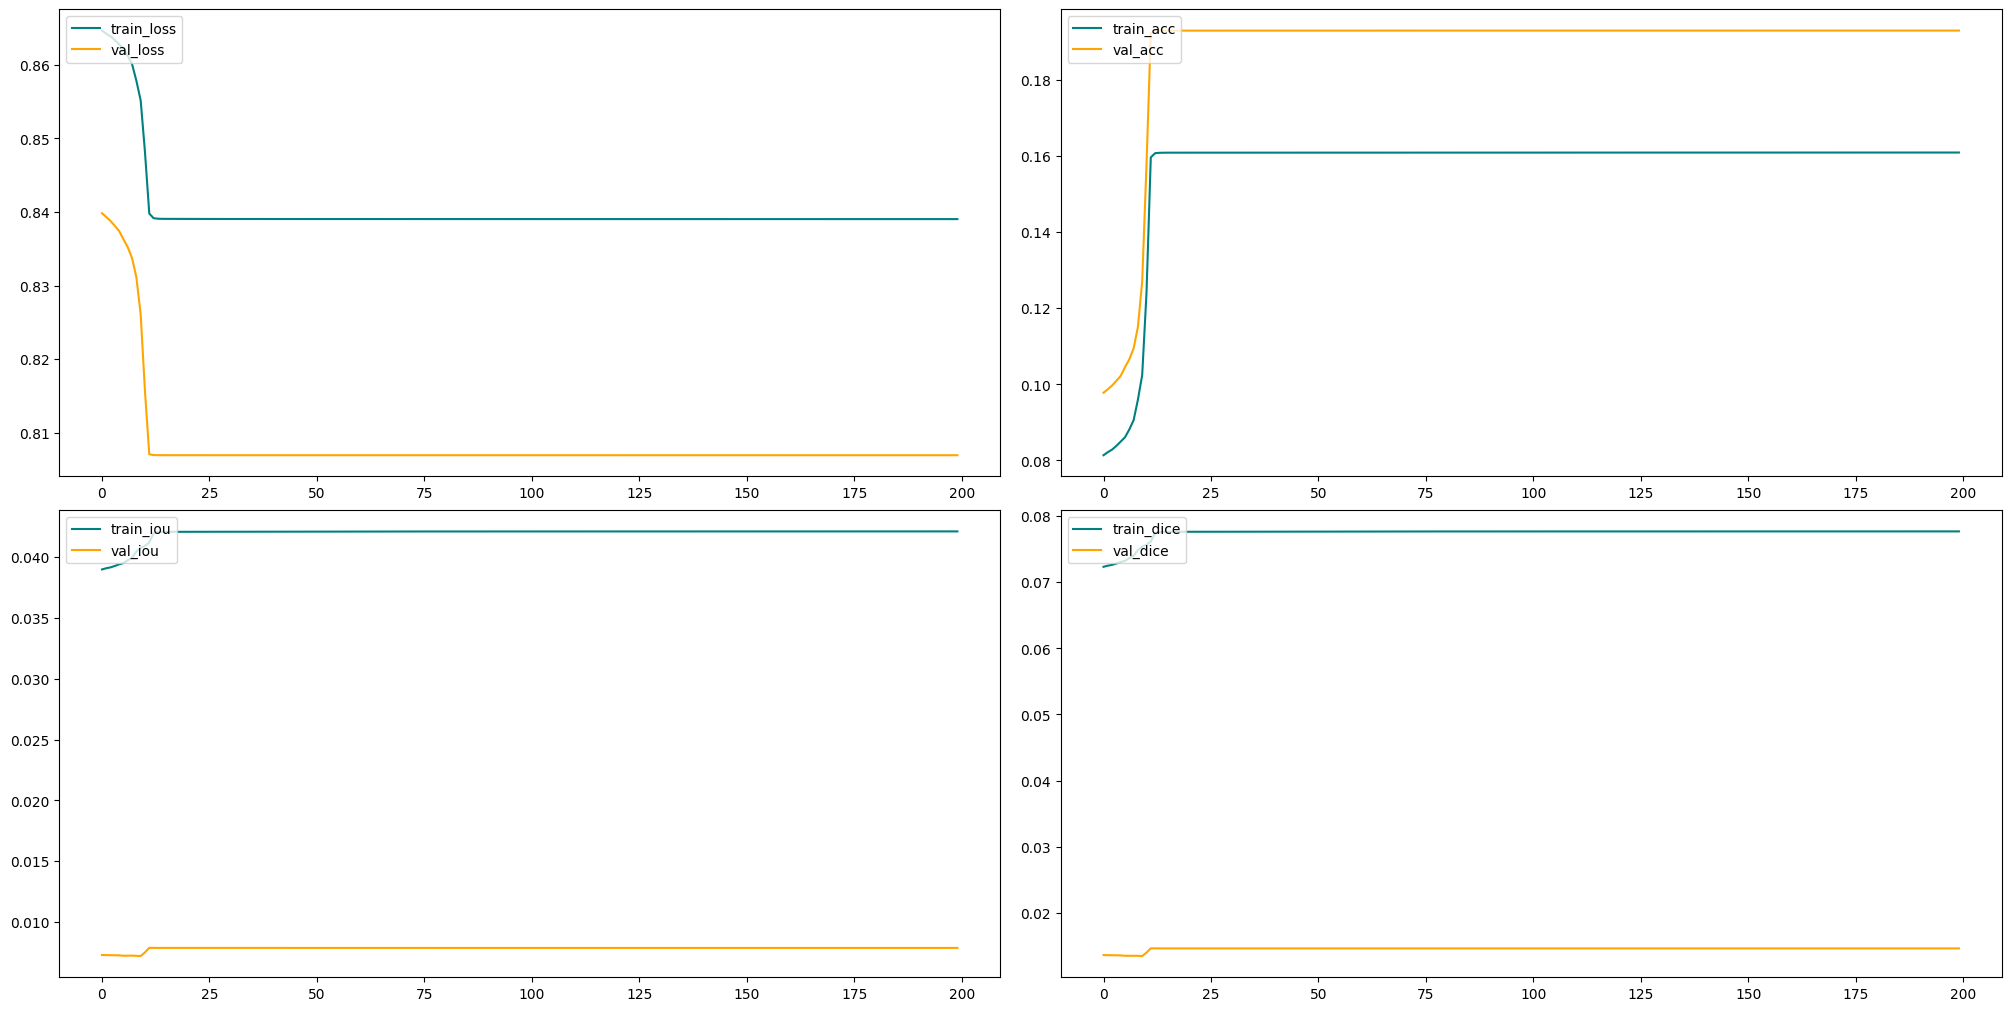

In [63]:
plt.rcParams['figure.figsize'] = [20, 10]
figure = plt.figure(figsize=(20,10))
fig, axs = plt.subplots(2, 2, constrained_layout = True)
epochs = [_ for _ in range(len(train_losses))]

axs[0][0].plot(epochs, train_losses, color='teal', label='train_loss')
axs[0][0].plot(epochs, val_losses, color='orange', label='val_loss')
axs[0][0].legend(loc='upper left')

axs[0][1].plot(epochs, train_accs, color='teal', label='train_acc')
axs[0][1].plot(epochs, val_accs, color='orange', label='val_acc')
axs[0][1].legend(loc='upper left')

axs[1][0].plot(epochs, train_ious, color='teal', label='train_iou')
axs[1][0].plot(epochs, val_ious, color='orange', label='val_iou')
axs[1][0].legend(loc='upper left')

axs[1][1].plot(epochs, train_dices, color='teal', label='train_dice')
axs[1][1].plot(epochs, val_dices, color='orange', label='val_dice')
axs[1][1].legend(loc='upper left')

## 2.2 Visualisation of segmentation map

In [64]:
def output_to_segmap(output_nparray, threshold = 0.5):
    
    """Converts model's output, a numpy array, into a segmentation map 
    
    Args:
        output_nparray: numpy array, model's output
        threshold: float, scalar to threshold predicted probability
    Returns:
        output_segmap: numpy array, segmentation map of model's output
    """
    
    output_segmap = np.where(output_nparray > 0.5, 1., 0.)
    output_segmap = output_segmap*255.
    return output_segmap

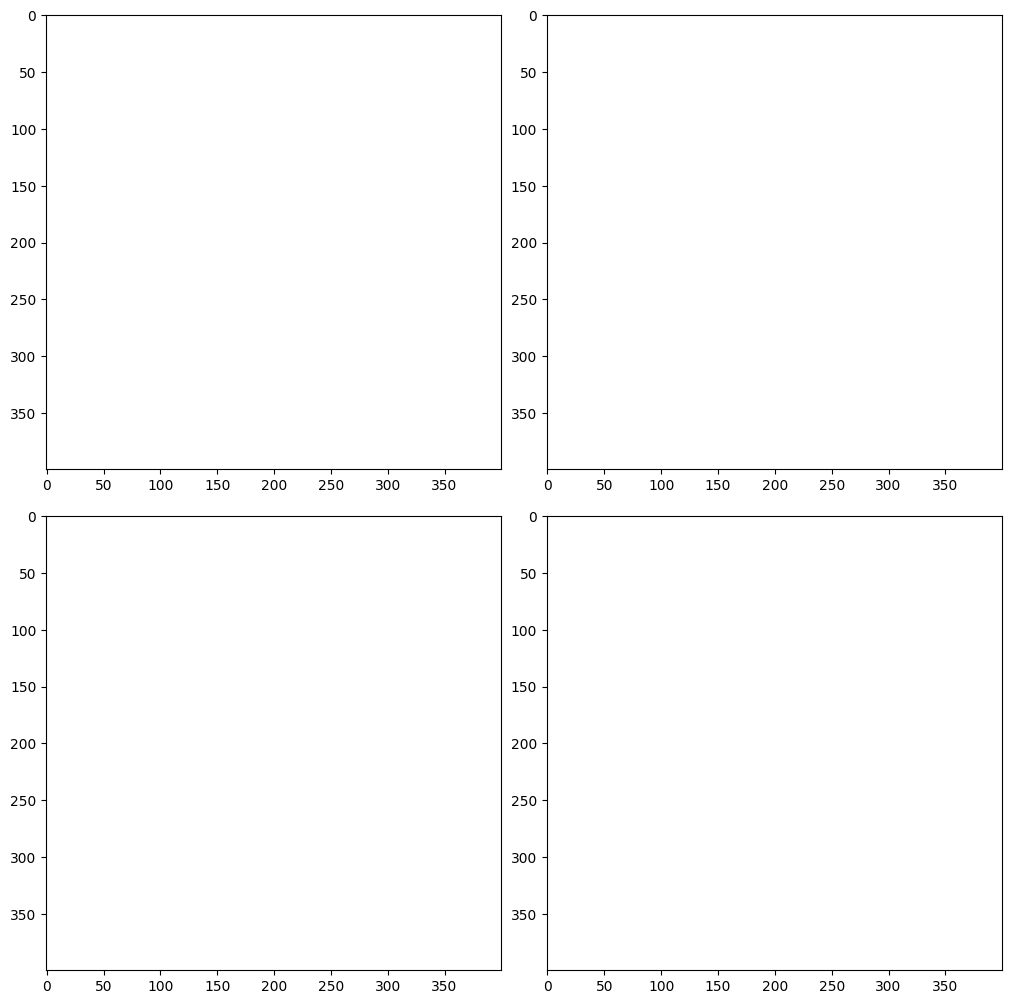

In [69]:
plt.rcParams['figure.figsize'] = [10, 10]
fig, axs = plt.subplots(2, 2, constrained_layout = True)

axs[0][0].imshow(output_to_segmap(np.load('train_epoch_25.npy')), cmap='gray', vmin = 0, vmax = 1)
axs[0][1].imshow(output_to_segmap(np.load('train_epoch_75.npy')), cmap='gray', vmin = 0, vmax = 1)
axs[1][0].imshow(output_to_segmap(np.load('train_epoch_125.npy')), cmap='gray', vmin = 0, vmax = 1)
axs[1][1].imshow(output_to_segmap(np.load('train_epoch_175.npy')), cmap='gray', vmin = 0, vmax = 1)

In [71]:
print(np.unique(np.load('train_epoch_25.npy')))
print(np.unique(np.load('train_epoch_75.npy')))
print(np.unique(np.load('train_epoch_125.npy')))
print(np.unique(np.load('train_epoch_175.npy')))

[0.6837713  0.70334685 0.7230405  ... 0.99999976 0.9999999  1.        ]
[0.7388846  0.76727915 0.78323334 0.8022145  0.8482384  0.8637027
 0.8650714  0.86613363 0.87005156 0.8830138  0.9064737  0.91742575
 0.9202514  0.9247974  0.92613024 0.9390349  0.94243985 0.9458763
 0.94660455 0.9472425  0.9525348  0.9529186  0.9543571  0.95651656
 0.9574148  0.96022654 0.96749264 0.96780026 0.9684322  0.9687676
 0.9717833  0.97575104 0.97643036 0.97765917 0.9777959  0.97841585
 0.9787941  0.98021734 0.9803192  0.9810585  0.9812701  0.9823751
 0.9827726  0.98440176 0.9847764  0.9850413  0.9867077  0.98775464
 0.9878626  0.98800385 0.98843247 0.98867303 0.98895663 0.9894302
 0.98989    0.9901715  0.99017197 0.99089855 0.9911327  0.9911923
 0.9917081  0.9917242  0.99189174 0.9922735  0.99273515 0.9931115
 0.99362165 0.9937682  0.9938698  0.9940165  0.994194   0.9942931
 0.99466974 0.99482864 0.9951238  0.995181   0.9951833  0.9952531
 0.99556136 0.99565    0.99567777 0.9957283  0.9958573  0.9958698
